# Coherence Tutorial.  

**The goal of this tutorial is to practice estimating the Noise and Signal from a neural response.**

The signal is the mean response.  This mean response is also what is predicted in the context of GLMs.  GLMs predict the mean of a Noise distribution (generally Normal, Poisson or Binomial).  

By estimating the mean and the noise directly from the data one can obtain the ceiling value of that can be predicted.  
The coherence is a measure of signal to noise ratio as a function of frequency.



## Dependencies
Make sure that you download the data and install all of the necessary requirements before running this code! See the following link for more details:

[Getting Started](../getting_started.ipynb)

In [1]:
from warnings import simplefilter
simplefilter('ignore')

In [2]:
%matplotlib inline

from glob import glob
import mne
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from numpy.fft import fftshift, ifft, fft, fftfreq

import mnespikes
plt.ion()

The next three sections allow you to load and visualize single unit data from
The theunissen lab. Your goals are:

1. Get familiar with this data structure
2. Load your own data in a similar structure.

For the Theunissen data you can specify a directory for three brain regions and three example neurons in each.: 'mld' is the avian auditory midbrain 'ov' is the avian auditory thalamus 'l2a' is the avian auditory cortex each region has a 'good', 'avg', and 'bad' dataset, corresponding to the signal to noise ratio, quantified by information values.

In the next few cells we are reading all of the data and storing it in a pandas data frame.
The data consists of stimulus-response pairs.  Here there are 10 trials per stimulus and therefore the same stimulus is used multiple times.  We are also going to select the stimulus/response files corresponding to conspecific song. 

To use this code on your own data, you will need to write your own data load function for your data.

### Set up the path

In [3]:
# Change this if you move around files
path_base = os.path.join('../')

# For example you can specify an entire path
# path_base = '/Users/frederictheunissen/Documents/Classes/Summer Course/2016/theunissen_tutorials'

data_files = glob(os.path.join(path_base, 'data', '*', '*', '*'))
# spikes = glob('../data/*/*/*')

### Read the data and store it into a pandas data frame

In [4]:
columns = ['location', 'quality', 'kind', 'number']
stims = {name: [] for name in columns}
stims['path'] = []
spikes = {name: [] for name in columns}
spikes['spike_times'] = []

# Loop through our datafiles and begin collecting information from each
for dfile in data_files:
    if 'stim' in dfile:
        prefix = 'stim'
    elif 'spike' in dfile:
        prefix = 'spike'
    else:
        # Skip because it's not a stim or spike file
        continue
    with open(dfile, 'r') as ff:
        # Pull metadata
        location_quality, kind, number = dfile.split(os.sep)[-3:]
        location, quality = location_quality.split('_')
        stimnumber = int(number.replace(prefix, ''))
        
        # If it's a stimulus file, grab the fields we want and store it with the other stim files
        if prefix == 'stim':
            dpath = ff.read().strip()
            this_columns = columns + ['path']
            iter_data = [location, quality, kind, stimnumber, dpath]
            for column, data in zip(this_columns, iter_data):
                stims[column].append(data)
        # If it's a spike file, read the spiketimes and append them to a spiketimes list
        elif prefix == 'spike':
            with open(dfile, 'r') as ff:
                spike_times = ff.readlines()
                spike_times = [ii.strip() for ii in spike_times]
                spike_times_float = []
                for trial in spike_times:
                    if len(trial) > 0:
                        this_times = np.array(trial.split(' '), dtype=float)
                    else:
                        this_times = np.array([])
                    spike_times_float.append(this_times)
            this_columns = columns + ['spike_times']
            iter_data = [location, quality, kind, stimnumber, spike_times_float]
            for column, data in zip(this_columns, iter_data):
                spikes[column].append(data)

# Wrap everything in a dataframe for some extra functionality
stims = pd.DataFrame(stims)
spikes = pd.DataFrame(spikes)
data = pd.merge(stims, spikes)

# Expand the data so that each row is a single instance
tmp_data = []
for ii, row in data.iterrows():
    for jj, trial in enumerate(row['spike_times']):
        this_data = row.copy()
        this_data['spike_times'] = trial
        this_data['repetition'] = jj
        tmp_data.append(this_data)
data = pd.DataFrame(tmp_data)
data = data.drop('number', axis=1)

# Finally convert all spike times to seconds (they are currently in milliseconds)
data['spike_times'] = data['spike_times'].apply(lambda a: [ii / 1e3 for ii in a])

In [5]:
# Displaying the panda data frame.
data

,kind,location,path,quality,spike_times,repetition
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.020156, 0.032031, 0.216187, 0.449343, 0.449...",0
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.01675, 0.031718, 0.079906, 0.126468, 0.2015...",1
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.016125, 0.103218, 0.152906, 0.241218, 0.276...",2
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.103843, 0.362, 0.451031, 0.504843, 0.561437...",3
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.021937, 0.035031, 0.070843, 0.112437, 0.127...",4
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.056187, 0.074812, 0.196718, 0.454781, 0.506...",5
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.506812, 0.591593, 0.647937, 0.713656, 1.035...",6
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.128562, 0.45475, 0.502218, 0.567156, 0.8016...",7
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.281062, 0.297656, 0.352562, 0.415468, 0.507...",8
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,[1.521625],9


# Preprocess audio

Here we are going to calculate a spectrogram for each unique sound file.  We are going to do this using the time-frequency routines from mne: Check out https://www.martinos.org/mne/stable/generated/mne.time_frequency.tfr_array_morlet.html#mne.time_frequency.tfr_array_morlet

Note - for spiking data there are 10 repetitions of audio for each file. This corresponds to a single audio file, which we'll load in here in order to calculate the spectrogram of each.

In [6]:
all_audio_files = data['path'].unique()

# Define the frequencies that will be extracted
# freqs = np.logspace(np.log10(500), np.log10(10000), 50)  
freqs = np.linspace(500, 10000, 50)

decimate = 32  # How much do we wish to decimate the resulting spectrogram
n_cycles = freqs // 100  # Now many cycles for each wavelet
spectrograms = {}
for audio_file in tqdm(all_audio_files):
    sfreq_audio, audio = wavfile.read(os.path.join(path_base, 'data', 'all_stims', audio_file))
    time_audio = np.arange(audio.shape[0]) / float(sfreq_audio)
    
    # Perform the TFR on this sound and store the result
    tfr = mne.time_frequency.tfr_array_morlet(audio[np.newaxis, np.newaxis, :],
                                              sfreq_audio, freqs, decim=decimate,
                                              n_cycles=n_cycles)
    sfreq_audio /= decimate
    spectrograms[audio_file] = tfr

100%|██████████| 104/104 [00:26<00:00,  3.15it/s]


[(500, 8000),

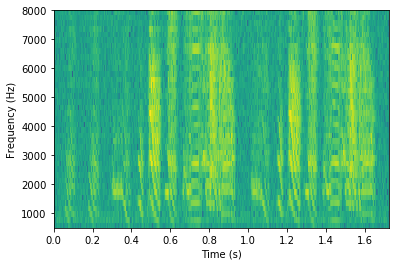

In [7]:
# Plot a spectrogram of a single stimulus as an example.  Here we choose the 4th stim.

plt_audio = spectrograms[all_audio_files[0]].squeeze()
time_audio = np.arange(plt_audio.shape[1]) / float(sfreq_audio)

fig, ax = plt.subplots()
ax.pcolormesh(time_audio, freqs, np.log(np.abs(plt_audio)))
ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)', ylim=[500, 8000])

[(500, 8000)]

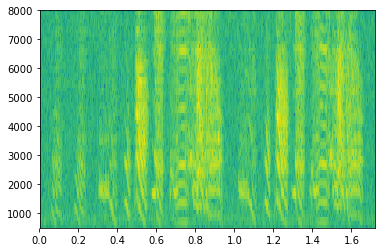

In [8]:
# NOTE: we could also use either matplotlib:
sfreq_audio, audio = wavfile.read(os.path.join(path_base, 'data', 'all_stims', all_audio_files[0]))
fig, ax = plt.subplots()
_ = ax.specgram(audio, Fs=sfreq_audio, NFFT=2**8)
ax.set(ylim=[500, 8000])


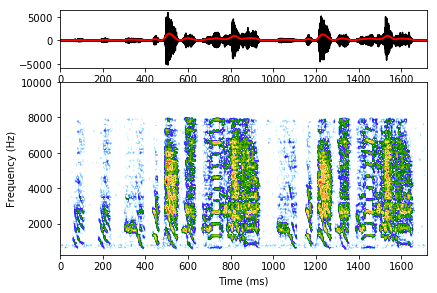

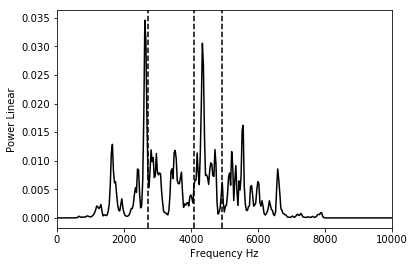

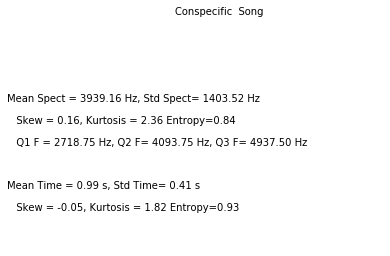

In [9]:
try:
    # Or use the theunissen lab soundsig.sound package.
    # Install soundsig from the theunissen github repo: https://github.com/theunissenlab/soundsig.git
    from soundsig.sound import BioSound

    # Read the audio from wave
    sfreq_audio, audio = wavfile.read(os.path.join(path_base, 'data', 'all_stims', all_audio_files[0]))

    # Make a BioSound object
    myBioSound = BioSound(soundWave=audio, fs=sfreq_audio, emitter='Conspecific', calltype = 'Song')

    # Extract some acoustical features
    # Calculate amplitude enveloppe
    myBioSound.ampenv()

    # Calculate the power spectrum
    myBioSound.spectrum(f_high=10000)

    # Calcualte the spectrogram
    myBioSound.spectroCalc(spec_sample_rate=500)

    # Plot it
    myBioSound.plot()
except:
   print("This code didn't work probably because you're on Python 3 instead of 2!")

[(500, 8000)]

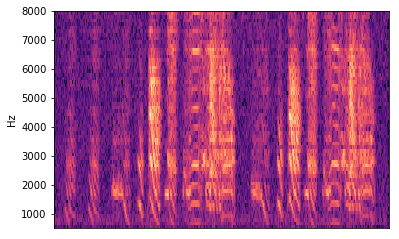

In [10]:
# Or we could also use librosa
# This is the most powerful for audio analysis, though it's kind of a pain to install
import librosa as lr
import librosa.display as lrd

# Define a gaussian window
gauss_std = 80
window = ('gaussian', gauss_std)

# Calculate / plot the STFT
stft = lr.stft(audio, window=window, n_fft=2**8)
ax = lrd.specshow(lr.amplitude_to_db(stft), sr=sfreq_audio, y_axis='linear')
ax.set(ylim=[500, 8000])

# Preprocess spikes
Neuronal spiking data is essentially a collection of times, with each timepoint corresponding to one spike. Each spike file contains multiple repetitions of the same stimulus. These spikes are all from the same neuron.

To do this we'll use a small helper package called `mne-spikes`. This lets you wrangle some spiking data and quickly output it as a timeseries. It also has the ability to output data in an MNE-python class, which makes it easy to visualize and analyze.

See the following links for more information about the `Neuron` class:

* http://predictablynoisy.com/mne-spikes/
* http://predictablynoisy.com/mne-spikes/_as_gen/mnespikes.Neuron.html#mnespikes.Neuron



In [11]:
# We are going to look at the data from one neuron from l2a that has poor signal to noise ratio.
this_location = 'l2a'
this_data = data.query('quality == "bad" and location == @this_location')
spikes = this_data['spike_times'].values

# We can use this to determine how to group our events.
# "kind" corresponds to the type of sound (e.g., conspecific)
# "path" corresponds to the file path of the sound
grouping_kind = 'path'
event_types = this_data[grouping_kind].values

# Store the spiking data in the Neuron class.
neuron = mnespikes.Neuron(spikes, sfreq=50.0, events=event_types,
                          tmin=-1, tmax=5, name='neuron_{}'.format(this_location))

neuron

Name: neuron_l2a | Num Events: 500 | Events: ['03E10DEDAE67801C0F3CB518A1274FDE.wav', 'CB3F8C1BDBEB75DAFF8D61406CC11E6C.wav', '3025AB70D44D439325A2FDA2713A2615.wav', '1FB89086195C9F44D1E71D036AA8FF3B.wav', '40F3FB128B622049FB74EFD8134F4BE9.wav', '5D25AB2ADA54F6D3D8F27DCC5578A42A.wav', 'B775C95A9E64A42DF1C9D1ED84950E31.wav', '3BA1C42A6AE1E749C9E5E6E2BFC53EE8.wav', 'DEB5A1D698864531775798C877E677C7.wav', '54515066DA9C08B25E1C8DE7BED455FB.wav', '5C77728562563CBAD315F88BE33D6974.wav', '814F71BF4D5A3BCA2D2FBFDEE534C404.wav', '12A537F4DAE82015A7D4270E4D896E7A.wav', '3FFBE3B1490DE23C60F195696138C5B2.wav', '4A65B753680068B4FDA79572295F993B.wav', '385745048146C0A71B3B2A6A84B03BF4.wav', 'A972CD10BAE3A93D8BC9FD9B0A661153.wav', 'D6E2826E7D682FFFD6DBB8E80B87DB22.wav', '008B5A5C0C3E76BFBF97278658FB6309.wav', 'F479E993BBE3F56A24A99C09F97C7DF2.wav', '3860E04C04E66ECAC4C8F32AB7429445.wav', '60CCCF4448DD26D3C8B89B2B1CA9DA15.wav', '62B9D347BB787094E2D844D3AAFC808C.wav', '1A556365C919DC0B02CF08D2D5CE4F7B.

In [12]:
epochs = neuron.to_mne()
# The 500 events correspond to 10 trials to 20 different song (conspecific), 10 trials to 10 different ml noise
# and 10 trials to 20 ml noise with bird spectra.

500 matching events found
0 projection items activated
0 bad epochs dropped


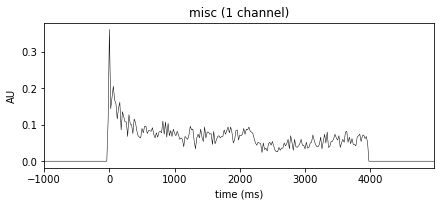

In [13]:
# As this is an MNE object, we can use MNE functions to do visualization.
# The `average` method averages across all trials.
av = epochs.average([0])
av.plot();

Next we'll select all of the trials that correspond to a single filename. Remember we'll have 10 repetitions per filename.

In [14]:
# Print a list of the file names in this MNE object
print(epochs.event_id.keys())

['03E10DEDAE67801C0F3CB518A1274FDE.wav', 'A972CD10BAE3A93D8BC9FD9B0A661153.wav', '3025AB70D44D439325A2FDA2713A2615.wav', '1FB89086195C9F44D1E71D036AA8FF3B.wav', '40F3FB128B622049FB74EFD8134F4BE9.wav', '385745048146C0A71B3B2A6A84B03BF4.wav', 'B775C95A9E64A42DF1C9D1ED84950E31.wav', '58C2739108AE5794D25F64CDDAF0F813.wav', '3BA1C42A6AE1E749C9E5E6E2BFC53EE8.wav', '54515066DA9C08B25E1C8DE7BED455FB.wav', '5C77728562563CBAD315F88BE33D6974.wav', '814F71BF4D5A3BCA2D2FBFDEE534C404.wav', '12A537F4DAE82015A7D4270E4D896E7A.wav', '3FFBE3B1490DE23C60F195696138C5B2.wav', '4A65B753680068B4FDA79572295F993B.wav', '5D25AB2ADA54F6D3D8F27DCC5578A42A.wav', 'CB3F8C1BDBEB75DAFF8D61406CC11E6C.wav', 'D6E2826E7D682FFFD6DBB8E80B87DB22.wav', '008B5A5C0C3E76BFBF97278658FB6309.wav', 'F479E993BBE3F56A24A99C09F97C7DF2.wav', '3860E04C04E66ECAC4C8F32AB7429445.wav', '60CCCF4448DD26D3C8B89B2B1CA9DA15.wav', '62B9D347BB787094E2D844D3AAFC808C.wav', '1A556365C919DC0B02CF08D2D5CE4F7B.wav', '62F3870218CF24F74169C1E22E69FACE.wav',

In [15]:
# Select trials of a particular condition type and clip to a maximum of 3 seconds
filename = '008B5A5C0C3E76BFBF97278658FB6309.wav'
tmin = -.5
tmax = 3
epochs_con = epochs[filename].crop(tmin, tmax)

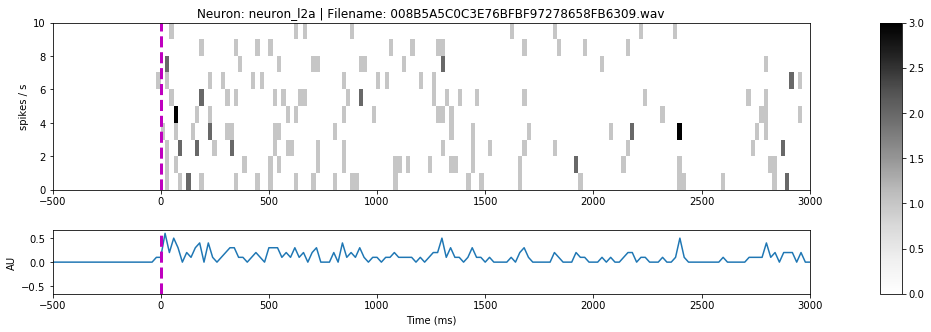

In [16]:
# Make a raster plot of the epochs along with the average response below.
### NOTE: If it seems like there are no spikes being plotted, try decreasing the sampling
### frequency of the Neuron when constructing it above. If there are too mnay timepoints, then the
### spike visualizations can get hidden by all of the whitespace.
picks = [0]  # This tells MNE which channel to plot...in this case, we have only one channel
fig = epochs_con.plot_image(picks, show=False, vmin=0, cmap='Greys')
fig[0].set_size_inches(15, 5)
fig[0].axes[0].set(ylabel='spikes / s', ylim=[0, None],
                   title='Neuron: {} | Filename: {}'.format(neuron.name, filename));

# Firing rate

In [17]:
epochs._data = mne.filter.filter_data(epochs._data, epochs.info['sfreq'], None, 5)

Setting up low-pass filter at 5 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 165 samples (3.300 sec) selected


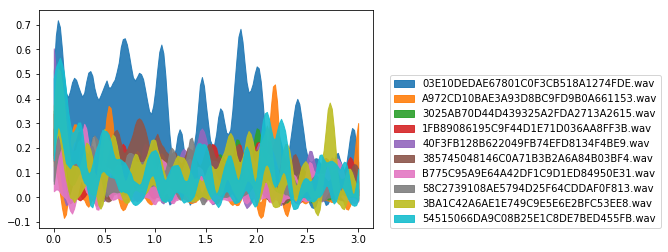

In [18]:
n_bootstraps = 100

fig, ax = plt.subplots()
cmap = plt.cm.tab10
plot_dtypes = list(epochs.event_id.keys())[:10]
for ii, dtype in enumerate(plot_dtypes):
    this_epochs = epochs[dtype].crop(0, 3)
    this_data = this_epochs._data.squeeze()
    this_color = cmap(float(ii) / len(plot_dtypes))
    boot_means = np.zeros([n_bootstraps, this_data.shape[-1]])
    ixs = np.random.randint(0, len(this_data), len(this_data) * n_bootstraps).reshape([n_bootstraps, -1])
    for boot, this_ix in enumerate(ixs):
        this_boot = this_data[this_ix].mean(0)
        boot_means[boot] = this_boot
        
    clo, chi = np.percentile(boot_means, [2.5, 97.5], axis=0)
    ax.fill_between(this_epochs.times, clo, chi, color=this_color, label=dtype, alpha=.9)
ax.legend(loc=(1.05, 0))

# Assignment 1: Calculate the noise for each trial and display it

Calculate the noise using a signal generated from all trials as well as a signal that does not incldue the trial for wich you calculate the noise

In [19]:
# Choose a very good neuron from the auditory midbrain.
quality = 'good'
location = 'mld'
name = '{}_{}'.format(quality, location)
this_data = data.query('quality == @quality and location == @location and kind=="conspecific"')

# Arguments used for filtering.
filt_kwargs = dict(l_freq=None, h_freq=20, verbose=False)

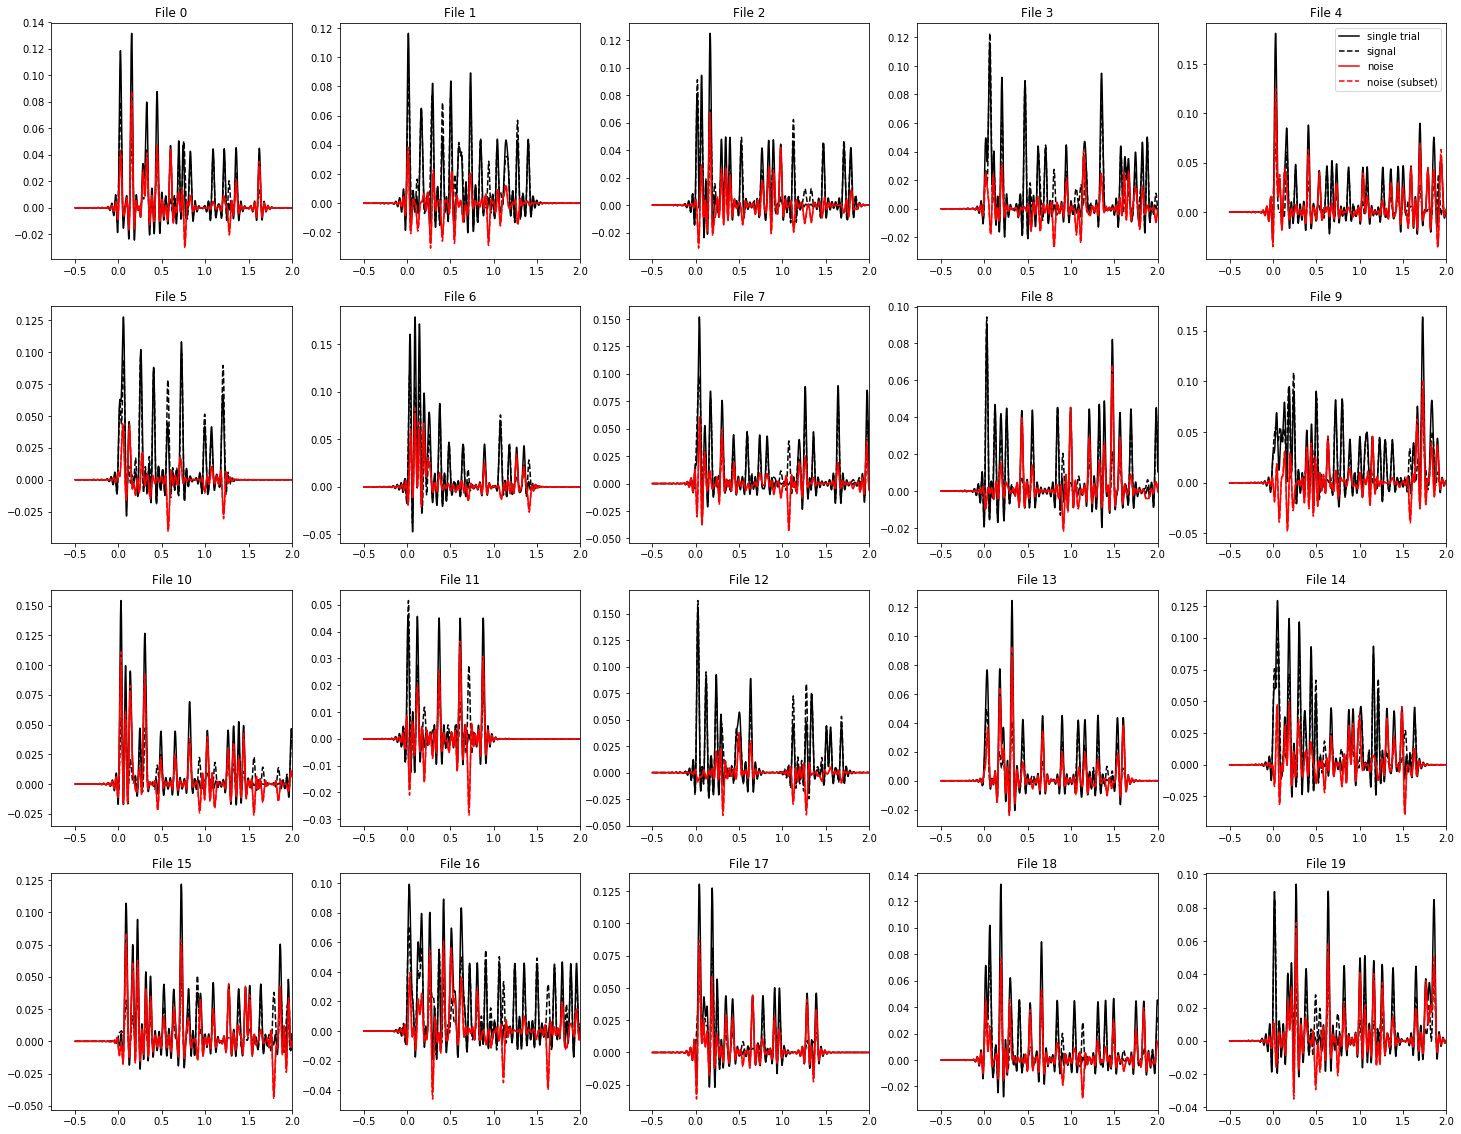

In [20]:
### We have started this loop that uses mnespikes.Neuron - see if you can fill it in to calculate the noise and
### the delete one noise

# Setting up a grid of plost
n_cols = 5
n_rows = int(np.ceil(len(this_data.groupby('path')) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

# List for the noise, the delete one noise (noise_subset) and the signal
noise_tot = []
noise_subset_tot = []
signal_tot = []

# Looping through all the data files that match the query.
for iifile, ((wavfile, i_data), ax) in enumerate(zip(this_data.groupby('path'), axs.ravel())):
    
    # Getting the data and storing it as a Neuron object
    spikes = i_data['spike_times'].values
    event_types = i_data['kind'].values
    neuron = mnespikes.Neuron(spikes, sfreq=1000.0, events=event_types,
                    tmin=-.5, tmax=5., name='neuron_{}'.format(name))
    
    # This is how you can calculate the mean (or psth)
    signal = neuron.spikes.mean(0)
    
    # Loooping through trials - as in the trial to be deleted
    for ii, trial in enumerate(neuron.spikes):
        ixs = list(range(i_data.shape[0]))
        ixs.pop(ii)   # Deletes the current trial from the list of trials
        
        # Make variables called: 
        #    signal_subset: the average signal with the current trial deleted
        #    noise_all: the noise for the current trial using the signal obtained from all trials
        #    noise_subset: the noise for the current trial using the signal obtained from all the other trials (deleting this one)
        #  Append: noise_all to noise_tot and noise_subset to noise_subset_tot.  We are going to use those later on to calculate
        # signal to noise ratios and coherence.
### BEGIN SOLUTION        
        signal_subset = neuron.spikes[ixs].mean(0)
        noise_all = trial - signal
        noise_subset = trial - signal_subset
        
        noise_subset_tot.append(noise_subset)
        noise_tot.append(noise_all)
        signal_tot.append(signal)
### END SOLUTION

        if ii == 0:
            ax.plot(neuron.time, mne.filter.filter_data(trial, neuron.sfreq, **filt_kwargs),
                    color='k', label='single trial')
            ax.plot(neuron.time, mne.filter.filter_data(signal, neuron.sfreq, **filt_kwargs),
                    color='k', ls='--', label='signal')
            ax.plot(neuron.time, mne.filter.filter_data(noise_all, neuron.sfreq, **filt_kwargs),
                    color='r', label='noise')
            ax.plot(neuron.time, mne.filter.filter_data(noise_subset, neuron.sfreq, **filt_kwargs),
                    color='r', ls='--', label='noise (subset)')
            ax.set(title='File {}'.format(iifile), xlim=[None, 2])
axs[0, -1].legend()

# Collect the saved signal / noise from each trial
noise_subset_tot = np.array(noise_subset_tot)
noise_tot = np.array(noise_tot)
signal_tot = np.array(signal_tot)

# Assignment 2: Calculate the noise and signal psd obtained by averaging and by averaging after deleting one. Is the noise white? Also plot the Signal to Noise ratio obtained in with the two estimates of noise

In [21]:
## Hint: to calculate the power spectra you can use mne's time-frequency power spectrum estimation routines.
## Eg. https://www.martinos.org/mne/stable/generated/mne.time_frequency.psd_array_welch.html#mne.time_frequency.psd_array_welch
## You are going to use signal_tot, noise_tot and noise_subset_tot calculated above.

# Calculate the three psd here (signal, noise, delete one noise)
### BEGIN SOLUTION
psignal, freqs = mne.time_frequency.psd_array_welch(signal_tot, neuron.sfreq, n_overlap=125)
pnoise, freqs = mne.time_frequency.psd_array_welch(noise_tot, neuron.sfreq, n_overlap=125)
pnoise_subset, freqs = mne.time_frequency.psd_array_welch(noise_subset_tot, neuron.sfreq, n_overlap=125)
### END SOLUTION

Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)


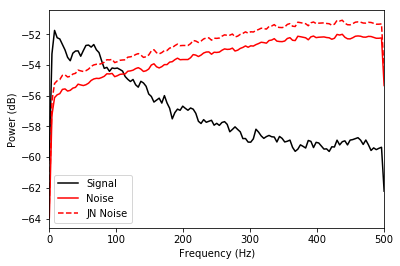

In [22]:
# Plot the psds here

### BEGIN SOLUTION
fig, ax = plt.subplots()
ax.plot(freqs, 10 * np.log10(psignal.mean(0)), c='k', label='Signal')
ax.plot(freqs, 10 * np.log10(pnoise.mean(0)), c='r', label='Noise')
ax.plot(freqs, 10 * np.log10(pnoise_subset.mean(0)), c='r', ls='--', label='JN Noise')

ax.set(xlim=[0, neuron.sfreq / 2], xlabel='Frequency (Hz)', ylabel='Power (dB)')
plt.legend()
### END SOLUTION

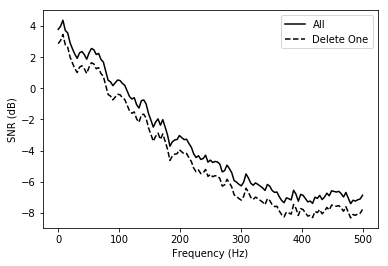

In [23]:
# Plot the SNR in dB units here

### BEGIN SOLUTION
fig, ax = plt.subplots()
ax.plot(freqs, 10.0*np.log10(psignal.mean(0) / pnoise.mean(0)), 'k', label='All')
ax.plot(freqs, 10.0*np.log10(psignal.mean(0) / pnoise_subset.mean(0)), 'k--', label='Delete One')
ax.set(ylabel='SNR (dB)', xlabel='Frequency (Hz)')
plt.legend()
### END SOLUTION

# Assignment 3: Is the noise gaussian?

### Hints: You can use the scipy.stats norm functions and matplotlib hist function. You might also want to low pass filter the noise and try different values of cutoff frequency (eg. 10 Hz, 100 Hz)


Setting up low-pass filter at 1e+02 Hz
h_trans_bandwidth chosen to be 25.0 Hz
Filter length of 264 samples (0.264 sec) selected


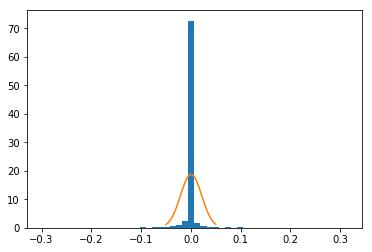

In [24]:
from scipy.stats import norm

### BEGIN SOLUTION
noise_subset_filt = mne.filter.filter_data(noise_subset, neuron.sfreq, None, 100)
noise_mu, noise_std = norm.fit(noise_subset_filt.ravel())

fig, ax = plt.subplots()
ax.hist(noise_subset_filt, bins=50, normed=True)

plt_x = np.linspace(-.05, .05, 100)
ax.plot(plt_x, norm.pdf(plt_x, noise_mu, noise_std))

### END SOLUTION

# Assignment 4: Calculate and display the coherence calculated from the signal to noise ratio. Calculate the information form this coherence.

In [25]:
# The coherence is S/(S+N)

# Add your calculation here

### BEGIN SOLUTION
coh_snr = psignal.mean(0) / (pnoise.mean(0) + psignal.mean(0))

# The information is obtained by integrating (summing) the log2(1 - coherence).
dfreq = freqs[1] - freqs[0]      # The delta frequency
info_snr = np.sum(-np.log2(1 - coh_snr)) * dfreq

coh_snr_d1 = psignal.mean(0) / (pnoise_subset.mean(0) + psignal.mean(0))
info_snr_d1 = np.sum(-np.log2(1 - coh_snr_d1)) * dfreq

### END SOLUTION

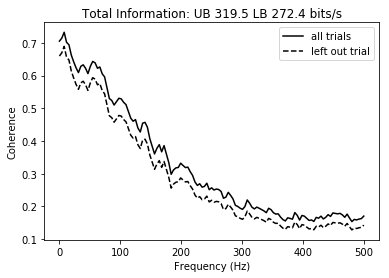

In [26]:
# Add your plot here

### BEGIN SOLUTION
fig, ax = plt.subplots()
ax.plot(freqs, coh_snr, 'k', label='all trials')
ax.plot(freqs, coh_snr_d1, 'k--', label='left out trial')
ax.set(ylabel='Coherence', xlabel='Frequency (Hz)',
       title='Total Information: UB {:.1f} LB {:.1f} bits/s'.format(
           info_snr, info_snr_d1))
ax.legend()
### END SOLUTION

# Model Performance Estimation using the Coherence.

We are now going to calculate the coherence and channel capacity (the upper bound) using Hsu, Borst, Theunissen methodology (Hsu, A., A. Borst and F. E. Theunissen (2004). "Quantifying variability in neural responses and its application for the validation of model predictions." Network 15(2): 91-109.)

In order to do that we need to take the raw spike times, split them into even and odd trials, and compute PSTHs for each half. We will also generate a fake prediction by adding noise to the psth.

### Divinding the data into Odd and Even Trials and obtaing the average response for each half

In [27]:
psthAll = []
psthEven = []
psthOdd = []

# Looping through selected data (this _data) in the pandas data frame.
for iifile, (wavfile, i_data) in enumerate(this_data.groupby('path')):
    
    # Making a Neuron Data Structure.
    spikes = i_data['spike_times'].values
    event_types = i_data['kind'].values
    neuron = mnespikes.Neuron(spikes, sfreq=1000.0, events=event_types,
                    tmax=5, name='neuron_{}'.format(ii))
    psth = neuron.spikes.mean(0)
    psth_odd = np.zeros(psth.shape)
    psth_even = np.zeros(psth.shape)
    n_odd = 0
    n_even = 0
    for ii, trial in enumerate(neuron.spikes):
        if ii % 2 != 0 :
            psth_odd += neuron.spikes[ii,:]
            n_odd += 1
        else:
            psth_even += neuron.spikes[ii,:]
            n_even += 1
    psth_odd /= n_odd
    psth_even /= n_even
    
    psthAll.append(psth)
    psthEven.append(psth_even)
    psthOdd.append(psth_odd)

psthAll = np.asarray(psthAll).ravel()
psthEven = np.asarray(psthEven).ravel()
psthOdd = np.asarray(psthOdd).ravel()

### A model prediction is obtained by adding gaussian noise to the data.

In [28]:
noiseGain = 0.05 # play with gain to increase or decrease PSTH corruption
noise = np.random.randn(psthAll.shape[0]) * noiseGain # make some noise!
prediction = psthAll + noise # corrupt PSTH

prediction[prediction < 0] = 0 # Rectify
prediction[prediction > 1] = 1 # Saturate

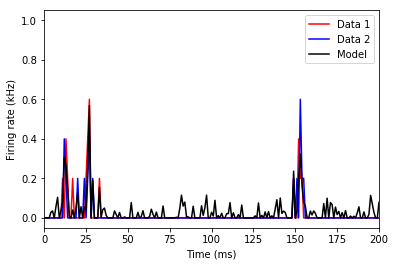

In [29]:
# Plot these 1/2 psths and the prediction.
fig, ax = plt.subplots()
ax.plot(psthEven, 'r', label = 'Data 1')
ax.plot(psthOdd, 'b', label = 'Data 2')
ax.plot(prediction, 'k', label = 'Model')
ax.set(xlabel='Time (ms)', ylabel='Firing rate (kHz)', xlim=[0, 200])
ax.legend()


### Defining a vanilla coherence function

In [30]:
def coherence(x, y, fsamp, nwindow):
    """A vanilla function to calculate the coherence between two 1d time series.
    """
    npts = len(x)    
    nchunk = int(npts/nwindow)
        
    # List to save values
    powx = []
    powy = []
    crossxy = []
    
    iend = 0
    for i in range(nchunk):
        istart = iend
        iend = istart + nwindow
        
        xchunk = x[istart:iend]
        ychunk = y[istart:iend]
        
        xf = fft(xchunk)
        yf = fft(ychunk)
        
        powx.append(np.real(xf*xf.conj())) 
        powy.append(np.real(yf*yf.conj()))
        
        crossxy.append(xf*yf.conj())
    
    freq = fftfreq(nwindow, 1.0/fsamp)
    
    pxx = np.asarray(powx).sum(0)
    pyy = np.asarray(powy).sum(0)
    cxy = np.asarray(crossxy).sum(0)
    
    
    coh = np.abs(cxy)**2/(pxx*pyy)
    
    return coh[:nwindow//2], freq[:nwindow//2]  # Double // means keep the dtype the same
        
    

## Calculation of the estimation of the coherences between one spike and the mean (cohBound) amd betweem one spike and the prediction (cohModel)

In [31]:
# Compute coherence between the two half psths:
fsamp = 1000.0
nwindow = 512
numTrials = 10 # Code should look for this number

# Coherence between two 1/2 of the psth and upper bound
coh_12, c_freqs = coherence(psthEven, psthOdd, fsamp, nwindow)
kdown = (-numTrials + numTrials * np.sqrt(1 / coh_12)) / 2       # Eq. 8 of Hsu et al.
cohBound = 1 / (kdown + 1)

# Coherence between the predicted and psth and prediction
coh_pred, c_freqs = coherence(prediction, psthAll, fsamp, nwindow)
rhs = (1 + np.sqrt(1.0 / coh_12)) / (-numTrials + numTrials*np.sqrt(1.0 / coh_12)+2) # rhs of Eq 11 in Hsu et. al
cohModel = coh_pred * rhs;

# Obtain Information values
dfreq = c_freqs[1] - c_freqs[0]      # The delta frequency
infoBound = np.sum(-np.log2(1 - cohBound)) * dfreq
infoModel = np.sum(-np.log2(1 - cohModel)) * dfreq

### Plot the results

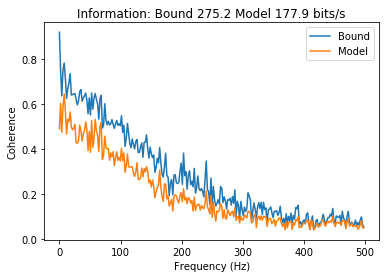

In [32]:
# Plot the results

fig, ax = plt.subplots()
ax.plot(c_freqs, cohBound, label='Bound')
ax.plot(c_freqs, cohModel, label='Model')
ax.set(ylabel='Coherence', xlabel='Frequency (Hz)', title='Information: Bound {:.1f} Model {:.1f} bits/s'.format(
    infoBound, infoModel))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
ax.legend()